In [1]:
# Avoid interference with GDAL from other external software due to environment variables used: GDAL_DATA and PROJ_LIB

import os
import getpass

usuario = getpass.getuser()

# os.environ['GDAL_DATA'] = f'/opt/anaconda3/envs/geoenv/share/gdal'
# os.environ['PROJ_LIB'] = f'/opt/anaconda3/envs/geoenv/share'

# en windows, NECESARIO EN AULA y seguramente en equipos con la misma instalación y SO
os.environ['GDAL_DATA'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\gdal'
os.environ['PROJ_LIB'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\proj'
os.environ['PATH'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\bin'

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray
import shapely
import sys
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import CRS
import contextily as ctx
from ipywidgets import interact, fixed
from pointpats import distance_statistics
from sklearn.cluster import DBSCAN
import seaborn as sns
from splot.esda import moran_scatterplot
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import lisa_cluster

C:\Users\Edush\anaconda3\envs\advprog\lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [3]:
#sys.argv[1] = "C:\\Users\\angel\\Documents\\Programacion_avanzada\\practicas\\Geodatos\\"
sys.argv[1] = "E:\\advprog\\p1\\Geodatos\\" 

In [4]:
eucal_cant = gpd.read_file(sys.argv[1] + "eucal_cant.shp")
cantabria = gpd.read_file(sys.argv[1] + "shp_cantabria\\cantabria.shp")
euc_mfe_cant = gpd.read_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\Eucaliptales_Cornisa_Cantabrica.shp")
mfe_cant = gpd.read_file(sys.argv[1] + "mfe_cantabria\\MFE_13.shp")

In [5]:
cantabria = cantabria.to_crs(eucal_cant.crs)
euc_mfe_cant = euc_mfe_cant[euc_mfe_cant["NUT3_NOM"] == "Cantabria"]

In [6]:
# Comprobamos que los sistemas de referencia estan correctos:
print(euc_mfe_cant.crs)

EPSG:25830
EPSG:25830


Primero probamos a hacer el índice de Moran con la capa que contiene solo poligonos con eucaliptos, que primero vamos a observar:

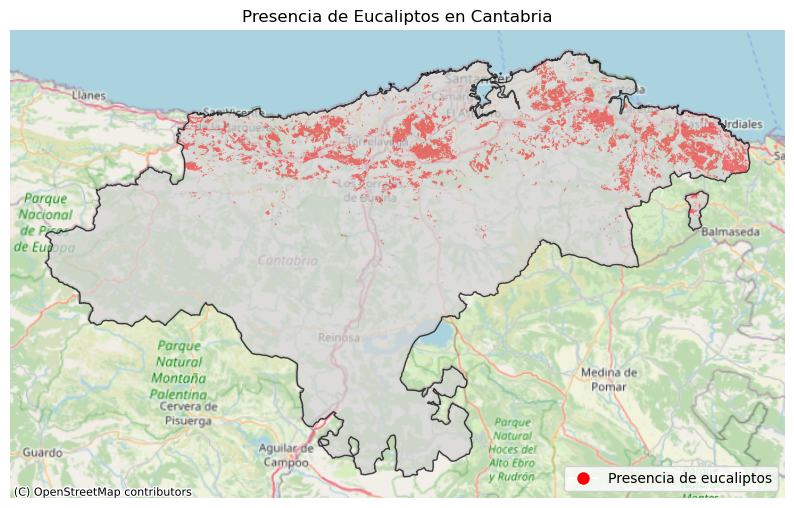

In [7]:
from matplotlib.lines import Line2D
# Crear la figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar límites de Cantabria
cantabria.plot(ax=ax, edgecolor='black', color='lightgray', alpha=0.7)

# Dibujar puntos de presencia de eucaliptos
euc_mfe_cant.plot(ax=ax, alpha=0.5, color='red', label='Presencia de eucaliptos')

# Añadir fondo de mapa
ctx.add_basemap(ax, crs=cantabria.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Mejorar el diseño
plt.title("Presencia de Eucaliptos en Cantabria")
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Presencia de eucaliptos')]

# Añadir la leyenda
ax.legend(handles=legend_elements, loc='lower right')
# Quitar ejes
ax.set_axis_off()

# Mostrar el mapa
plt.show()

Como ya hemos visto, los eucaliptales estan bastante dispersos y van a aparecer multitud de "islas" al calcular los pesos. Vamos a eliminar ese warning 

In [8]:
especies = euc_mfe_cant['n_sp1']

w_queen = weights.Queen.from_dataframe(euc_mfe_cant, silence_warnings=True, use_index=True)

moran = esda.Moran(especies, w_queen)

print(f"Índice de Moran: {moran.I}")
print(f"Valor p: {moran.p_sim}")


Índice de Moran: 0.14405668661201262
Valor p: 0.022


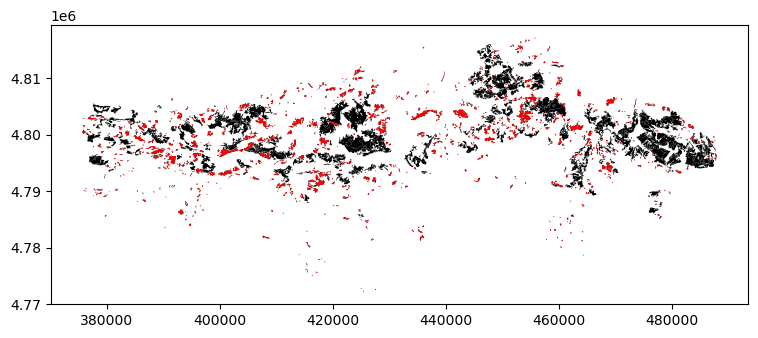

In [9]:
# Por confirmar, vamos a ver que valores son considerados como islas
w = w_queen = weights.Queen.from_dataframe(euc_mfe_cant, silence_warnings=True, use_index=True)
ax = euc_mfe_cant.plot(color='k', figsize=(9, 9))
euc_mfe_cant.loc[w.islands, :].plot(color='red', ax=ax);

Como es de esperar no parece haber gran correlación espacial, pero esto de momento no es correcto ya que no hemos resuelto el problema de las islas, aunque si hayamos silenciado las alertas. Vamos a hacer que mida la correlación con el vecino mas cercano.

In [10]:

especies = euc_mfe_cant['n_sp1']

w_queen = weights.Queen.from_dataframe(euc_mfe_cant, silence_warnings=True, use_index=True)

w_knn = weights.KNN.from_dataframe(euc_mfe_cant, k=1)  # k=1 = vecino más cercano

w_combined = weights.w_union(w_queen, w_knn)

C:\Users\Edush\anaconda3\envs\advprog\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 513 disconnected components.
  warnings.warn(message)
C:\Users\Edush\anaconda3\envs\advprog\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 328 disconnected components.
  warnings.warn(message)


In [11]:
#print(w_combined.neighbors)  # Con esto podemos ver las conexiones, pero son miles y tampoco nos aportan demasiado.

Ahora vamos a tratar de calcular el indice de moran con nuestros nuevos datos:

In [12]:
especies = euc_mfe_cant['n_sp1']

moran = esda.Moran(especies, w_combined)

print(f"Índice de Moran: {moran.I}")
print(f"Valor p: {moran.p_sim}")


Índice de Moran: 0.4557377086995233
Valor p: 0.001


Vemos así, como si que tenemos una correlación espacial significativa (p < 0.05) y como estos datos aparecen sobre todo agrupados, ya que el indice de moran se acerca mas a 1 que a -1.

Vamos a unir la capa de poligonos con la de puntos para hacer un conteo de eucaliptos por zona para poder analizar una variable continua con el índice de moran. No es el caso ideal, ya que este número es un conteo realizado por gente, con criterios distintos, pero nos servirá como ejemplo práctico.
Vamos a realizar una union, podemos limpiar nuestra tabla de columnas que no vamos a necesitar
para hacerlo mas sencillo.

In [13]:
print(euc_mfe_cant.columns)
eliminar = ['O1', 'n_estado1', 'Estado1', 'n_sp2', 'Especie2', 'O2', 'n_estado2',
       'Estado2', 'n_sp3', 'Especie3', 'O3', 'n_estado3', 'Estado3', 'FCCMAT',
       'n_FORmat', 'FormArbust', 'HMMAT', 'FCCHER', 'n_FORHER', 'FormHerbac',
       'n_ATRIBUTO', 'atributo', 'FCCTOT', 'n_MODCOM', 'ModeloComb',
       'TIPOBOSQUE', 'n_CLAIFN', 'UsoIFN', 'n_CLAMFE', 'UsoMFE', 'n_REGBIO',
       'RegBio', 'LULUCF', 'Shape_Area', 'layer', 'path','w_n_sp1']
euc_mfe_cant = euc_mfe_cant.drop(columns=eliminar, errors="ignore")
print(euc_mfe_cant.columns)



Index(['Poligon', 'ORIGEN', 'PRO_F', 'ccaa_F', 'ESTRATOIFN', 'Superficie',
       'NUT2_NOM', 'NUT3_NOM', 'TipesTR25', 'DesTipEstr', 'FCCARB', 'FORARB',
       'FormArbol', 'n_distribu', 'Distribuci', 'n_sp1', 'Especie1', 'O1',
       'n_estado1', 'Estado1', 'n_sp2', 'Especie2', 'O2', 'n_estado2',
       'Estado2', 'n_sp3', 'Especie3', 'O3', 'n_estado3', 'Estado3', 'FCCMAT',
       'n_FORmat', 'FormArbust', 'HMMAT', 'FCCHER', 'n_FORHER', 'FormHerbac',
       'n_ATRIBUTO', 'atributo', 'FCCTOT', 'n_MODCOM', 'ModeloComb',
       'TIPOBOSQUE', 'n_CLAIFN', 'UsoIFN', 'n_CLAMFE', 'UsoMFE', 'n_REGBIO',
       'RegBio', 'LULUCF', 'Shape_Area', 'layer', 'path', 'geometry'],
      dtype='object')
Index(['Poligon', 'ORIGEN', 'PRO_F', 'ccaa_F', 'ESTRATOIFN', 'Superficie',
       'NUT2_NOM', 'NUT3_NOM', 'TipesTR25', 'DesTipEstr', 'FCCARB', 'FORARB',
       'FormArbol', 'n_distribu', 'Distribuci', 'n_sp1', 'Especie1',
       'geometry'],
      dtype='object')


In [14]:
euc_mfe_cant.to_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\eucaliptales_simple.shp")

In [15]:
print(euc_mfe_cant.columns)

Index(['Poligon', 'ORIGEN', 'PRO_F', 'ccaa_F', 'ESTRATOIFN', 'Superficie',
       'NUT2_NOM', 'NUT3_NOM', 'TipesTR25', 'DesTipEstr', 'FCCARB', 'FORARB',
       'FormArbol', 'n_distribu', 'Distribuci', 'n_sp1', 'Especie1',
       'geometry'],
      dtype='object')


De nuevo lo limitamos a cantabria, y hacemos el join y reciclando del caso anterior, representamos el grafico del conteo.

In [16]:
euc_mfe_simpl = gpd.read_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\eucaliptales_simple.shp")
euc_mfe_simpl = euc_mfe_simpl[euc_mfe_simpl["NUT3_NOM"] == "Cantabria"]

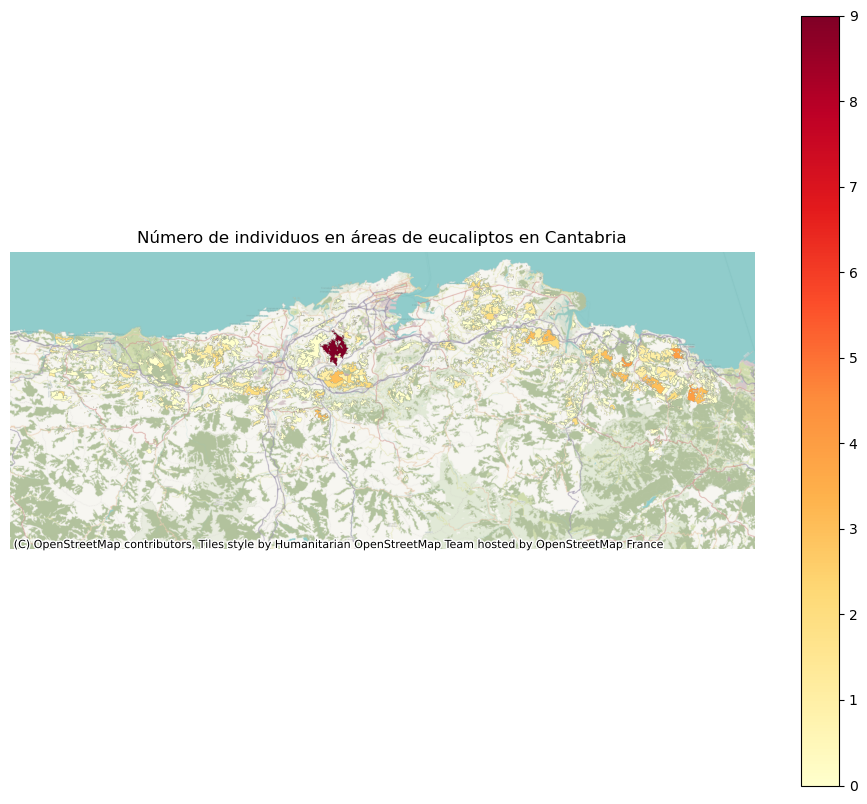

In [17]:

# Hacer una unión espacial para asignar cada punto a su municipio
joined = gpd.sjoin(eucal_cant, euc_mfe_simpl, how="inner", predicate="within")

# Contar el número de puntos por municipio
conteo = joined.groupby("index_right").size().reset_index(name="euc_count")

# Añadir el conteo a la tabla de municipios
conteo_eucal = euc_mfe_simpl.join(conteo.set_index("index_right"))

# Rellenar con 0 los municipios sin eucaliptos (si es necesario)
conteo_eucal["euc_count"] = conteo_eucal["euc_count"].fillna(0).astype(int)

# Guardar el resultado en un nuevo shapefile
conteo_eucal.to_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\conteo_eucaliptos.shp")

# Mostrar el resultado
fig, ax = plt.subplots(figsize=(12, 10))

# Dibujar municipios coloreando por el número de eucaliptos
conteo_eucal.plot(
    column="euc_count",
    cmap="YlOrRd",
    edgecolor="grey",
    linewidth=0.1,
    legend=True,
    ax=ax
)

ctx.add_basemap(ax, crs=conteo_eucal.crs, zoom=12)  
# Añadir título y mejorar diseño
plt.title("Número de individuos en áreas de eucaliptos en Cantabria")
ax.set_axis_off()

plt.show()


Ahora vamos a calcular el desfase espacial del conteo de eucaliptos. Tras esto realizaremos la desviacion estandar de este valor y del conteo de eucaliptos, y con estos generamos el grafico de Moran.

In [36]:
euc_mfe_simpl = gpd.read_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\conteo_eucaliptos.shp")

In [37]:
euc_mfe_simpl['w_euc_count'] = weights.lag_spatial(w, euc_mfe_simpl['euc_count'])

In [20]:
euc_mfe_simpl[['Especie1', 'euc_count', 'w_euc_count']].head()

,Especie1,euc_count,w_euc_count
0,Eucalyptus globulus,0,0.0
1,Eucalyptus globulus,0,0.0
2,Eucalyptus globulus,0,0.0
3,Eucalyptus globulus,0,1.0
4,Eucalyptus globulus,0,0.0


In [21]:
euc_mfe_simpl['euc_count_std'] = (
    euc_mfe_simpl['euc_count'] - euc_mfe_simpl['euc_count'].mean()
) / euc_mfe_simpl['euc_count'].std()

In [38]:
euc_mfe_simpl['w_euc_count_std'] = weights.lag_spatial(w, euc_mfe_simpl['euc_count_std'])
euc_mfe_simpl.head()

KeyError: 'euc_count_std'

In [23]:
moran_i = esda.Moran(euc_mfe_simpl['euc_count'], w)

In [24]:
print(f"I de Moran: {moran_i.I}")
print(f"p = {moran_i.p_sim}")

I de Moran: 0.17329450126249277
p = 0.009


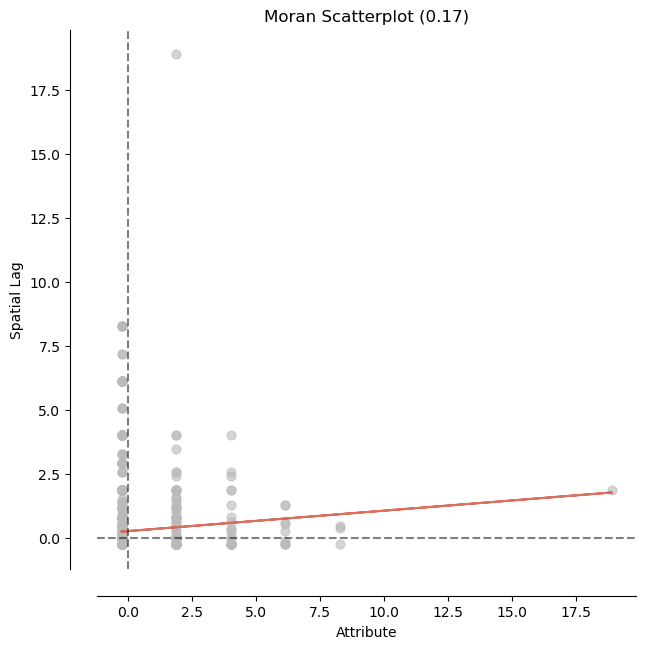

In [25]:
moran_scatterplot(moran_i);

Como ya hemos comentado la disponibilidad de datos continuos es la que es, y posiblemente sea la razon por la que el gráfico queda de esta manera, ya que según el calculo del indice de correlación, esta si que existía, y viendo este gráfico nos puede llevar a pensar que no es así. Seguiremos explorando nuestros datos calculando la correlación espacial local o LISA de esta variable.
Primero vamos a calcular el propio indice, y tras esto vamos a identificar los valores estadisticamente significativos, dato que añadiremos a una columna de nuestros datos. Asimismo

In [26]:
lisa = esda.Moran_Local(euc_mfe_simpl['euc_count'], w)

In [33]:
euc_mfe_simpl['significant'] = lisa.p_sim < 0.05
euc_mfe_simpl['quadrant'] = lisa.q

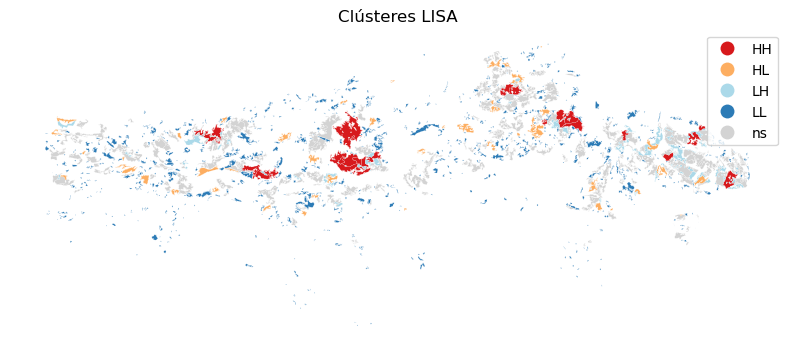

In [35]:

fig, ax = plt.subplots(figsize=(10, 10))
lisa_cluster(lisa, euc_mfe_simpl, p=0.05, ax=ax)
ax.set_title("Clústeres LISA")
plt.show()

Con estos resultados vemos identificados varios sectores donde la presencia, o en este caso, medición del número de eucaliptos es claramente mayor y como hay celulas de pequeñas cantidades de eucalipto repartidas de manera relativamente homogénea por el territorio.